In [2]:
# importing required libraries / packages

%matplotlib inline

import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle 
import os 

nltk.download('vader_lexicon')

from scipy. sparse import csr_matrix
from xgboost import XGBClassifier
from sklearn import tree
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn import metrics 
from tqdm import tqdm
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import randint
from prettytable import PrettyTable

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

In [4]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 15.8 MB/s 


In [5]:
%load_ext autotime

time: 530 µs (started: 2022-11-08 01:27:54 +00:00)


In [7]:
#please use  glove vectors if you are using TFIDF + W2V vectorization in this code
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

time: 2.32 s (started: 2022-11-08 01:27:54 +00:00)


In [10]:
# loading the preprocessed data, can check number of records using 'nrows'
data = pd.read_csv('preprocessed_project_data.csv', nrows = 50000)

time: 2.23 s (started: 2022-11-08 01:30:20 +00:00)


In [11]:
# checking for any Null values
data.isnull().sum()

teacher_prefix                                   0
school_state                                     0
project_grade_category                           0
project_subject_categories                       0
project_subject_subcategories                    0
project_title                                   23
project_resource_summary                         0
teacher_number_of_previously_posted_projects     0
project_is_approved                              0
essay                                            0
price                                            0
quantity                                         0
negative_score                                   0
positive_score                                   0
neutral_score                                    0
compound_score                                   0
dtype: int64

time: 44 ms (started: 2022-11-08 01:30:38 +00:00)


In [12]:
data.shape

(50000, 16)

time: 4.51 ms (started: 2022-11-08 01:30:42 +00:00)


In [13]:
# we are removing null values present in project title column since they are of very small in number
data = data.dropna( axis=0, how="any", thresh = None, subset = None, inplace = False)

time: 43.8 ms (started: 2022-11-08 01:30:44 +00:00)


In [14]:
data.shape

(49977, 16)

time: 4.85 ms (started: 2022-11-08 01:30:47 +00:00)


In [15]:
data.isnull().sum() # now we have no null values in our data

teacher_prefix                                  0
school_state                                    0
project_grade_category                          0
project_subject_categories                      0
project_subject_subcategories                   0
project_title                                   0
project_resource_summary                        0
teacher_number_of_previously_posted_projects    0
project_is_approved                             0
essay                                           0
price                                           0
quantity                                        0
negative_score                                  0
positive_score                                  0
neutral_score                                   0
compound_score                                  0
dtype: int64

time: 51.6 ms (started: 2022-11-08 01:30:50 +00:00)


In [16]:
y = data['project_is_approved'].values # storing the values of the column 'project_is_approved' in a variable 'y'
x = data.drop(['project_is_approved'], axis = 1)  # droping the column 'project_is_approved' from our original data and storing rest of the values in 'x'

time: 11.4 ms (started: 2022-11-08 01:30:53 +00:00)


In [ ]:
#yy = pd.DataFrame(y)

time: 1.11 ms (started: 2022-09-02 05:36:53 +00:00)


In [ ]:
#yy.value_counts() 

1    29614
0     5366
dtype: int64

time: 9.83 ms (started: 2022-09-02 05:36:53 +00:00)


In [17]:
x.head(1)

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,essay,price,quantity,negative_score,positive_score,neutral_score,compound_score
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,students need opportunities practice beginning...,0,students english learners working english seco...,154.6,23,0.013,0.154,0.833,0.9694


time: 30.7 ms (started: 2022-11-08 01:30:55 +00:00)


# Task 1 
Splitting the data into Train and Test

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, stratify = y ) # splitting the data into train, test with test data= 25% of values and  strtify on 'Y' label

time: 36.1 ms (started: 2022-11-08 01:30:57 +00:00)


In [ ]:
'''
y_testtt = pd.DataFrame(y_test)
y_testtt.value_counts()
'''

1    7404
0    1341
dtype: int64

time: 8.38 ms (started: 2022-09-02 05:36:53 +00:00)


In [20]:
print(" Number of rows and columns in Training data ", x_train.shape)
print(" Number of rows and columns in Test data ", x_test.shape)

 Number of rows and columns in Training data  (37482, 15)
 Number of rows and columns in Test data  (12495, 15)
time: 1.11 ms (started: 2022-11-08 01:31:11 +00:00)


### Applying TFIDF to the 'essay' column

In [21]:
vectorizer_tfidf = TfidfVectorizer(min_df = 10, max_features = 5000)        
vectorizer_tfidf.fit(x_train['essay'].values)

# we use fitted TFIDF to convert the text to vector 
x_train_essay_tfidf = vectorizer_tfidf.transform(x_train['essay'].values)
x_test_essay_tfidf = vectorizer_tfidf.transform(x_test['essay'].values)

time: 9.35 s (started: 2022-11-08 01:31:19 +00:00)


In [22]:
type(x_train_essay_tfidf)

scipy.sparse.csr.csr_matrix

time: 4.81 ms (started: 2022-11-08 01:31:31 +00:00)


In [23]:
print("Using TFIDF representation on 'Essay' column")
print("="*30)
print("Before Vectorization:")
print("-"*22)
print("Number of rows and columns in Train data are", x_train.shape)
print("Number of rows and columns in Test data are", x_test.shape)
print('\n')
print("After Vectorization:")
print("-"*21)
print("Number of rows and columns in Train data are", x_train_essay_tfidf.shape)
print("Number of rows and columns in Test data are", x_test_essay_tfidf.shape)
print('\n')

Using TFIDF representation on 'Essay' column
Before Vectorization:
----------------------
Number of rows and columns in Train data are (37482, 15)
Number of rows and columns in Test data are (12495, 15)


After Vectorization:
---------------------
Number of rows and columns in Train data are (37482, 5000)
Number of rows and columns in Test data are (12495, 5000)


time: 3.54 ms (started: 2022-11-08 01:31:34 +00:00)


### Applying TFIDF to the 'project_title' column

In [24]:
vectorizer_tfidf_title = TfidfVectorizer(min_df = 10, max_features = 5000)        
vectorizer_tfidf_title.fit(x_train['project_title'].values)

# we use fitted TFIDF to convert the text to vector 
x_train_title_tfidf = vectorizer_tfidf_title.transform(x_train['project_title'].values)
x_test_title_tfidf = vectorizer_tfidf_title.transform(x_test['project_title'].values)

time: 551 ms (started: 2022-11-08 01:31:39 +00:00)


In [25]:
type(x_train_title_tfidf)

scipy.sparse.csr.csr_matrix

time: 4.2 ms (started: 2022-11-08 01:31:41 +00:00)


In [26]:
print("Using TFIDF representation on 'Project Title' column")
print("="*30)
print("Before Vectorization:")
print("-"*22)
print("Number of rows and columns in Train data are", x_train.shape)
print("Number of rows and columns in Test data are", x_test.shape)
print('\n')
print("After Vectorization:")
print("-"*21)
print("Number of rows and columns in Train data are", x_train_title_tfidf.shape)
print("Number of rows and columns in Test data are", x_test_title_tfidf.shape)

Using TFIDF representation on 'Project Title' column
Before Vectorization:
----------------------
Number of rows and columns in Train data are (37482, 15)
Number of rows and columns in Test data are (12495, 15)


After Vectorization:
---------------------
Number of rows and columns in Train data are (37482, 1694)
Number of rows and columns in Test data are (12495, 1694)
time: 10.5 ms (started: 2022-11-08 01:31:44 +00:00)


## Applying TFIDF to the 'project_resource_summary' column

In [27]:
vectorizer_tfidf_project_resource_summary = TfidfVectorizer(min_df = 10, max_features = 5000)        
vectorizer_tfidf_project_resource_summary.fit(x_train['project_resource_summary'].values)

# we use fitted TFIDF to convert the text to vector 
x_train_project_resource_summary_tfidf = vectorizer_tfidf_project_resource_summary.transform(x_train['project_resource_summary'].values)
x_test_project_resource_summary_tfidf = vectorizer_tfidf_project_resource_summary.transform(x_test['project_resource_summary'].values)

time: 1.17 s (started: 2022-11-08 01:31:47 +00:00)


In [28]:
print("Using TFIDF representation on 'Project Resource Summary' column")
print("="*65)
print("Before Vectorization:")
print("-"*22)
print("Number of rows and columns in Train data are", x_train.shape)
print("Number of rows and columns in Test data are", x_test.shape)
print('\n')
print("After Vectorization:")
print("-"*21)
print("Number of rows and columns in Train data are", x_train_project_resource_summary_tfidf.shape)
print("Number of rows and columns in Test data are", x_test_project_resource_summary_tfidf.shape)

print('\n')


Using TFIDF representation on 'Project Resource Summary' column
Before Vectorization:
----------------------
Number of rows and columns in Train data are (37482, 15)
Number of rows and columns in Test data are (12495, 15)


After Vectorization:
---------------------
Number of rows and columns in Train data are (37482, 3342)
Number of rows and columns in Test data are (12495, 3342)


time: 5.21 ms (started: 2022-11-08 01:31:49 +00:00)


### Applying TFIDF + W2V to the 'essay' column

In [29]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

time: 4.01 s (started: 2022-11-08 01:31:53 +00:00)


for Train data

In [30]:
# average Word2Vec
# compute average word2vec for each review.
train_essay_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_essay_tfidf_w2v.append(vector)

print(len(train_essay_tfidf_w2v))
print(len(train_essay_tfidf_w2v[0]))

100%|██████████| 37482/37482 [01:23<00:00, 450.63it/s]

37482
300
time: 1min 23s (started: 2022-11-08 01:32:00 +00:00)


In [31]:
x_train_essay_tfidf_w2v = csr_matrix(train_essay_tfidf_w2v)

time: 537 ms (started: 2022-11-08 01:33:25 +00:00)


for Test data

In [32]:
# Similarly you can vectorize for title also
# average Word2Vec
# compute average word2vec for each review.
test_essay_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_essay_tfidf_w2v.append(vector)

print(len(test_essay_tfidf_w2v))
print(len(test_essay_tfidf_w2v[0]))

100%|██████████| 12495/12495 [00:27<00:00, 459.42it/s]

12495
300
time: 27.2 s (started: 2022-11-08 01:33:26 +00:00)


In [33]:
x_test_essay_tfidf_w2v = csr_matrix (test_essay_tfidf_w2v)

time: 144 ms (started: 2022-11-08 01:33:53 +00:00)


In [34]:
print("Training data of 'Essay' column:")
print("="*30)
print("total rows in our Test data :",x_train_essay_tfidf_w2v.shape)
print('\n')
print("Testing data of 'Essay' column:")
print("="*30)
print("total rows in our Train data :",x_test_essay_tfidf_w2v.shape)
print('\n')

Training data of 'Essay' column:
total rows in our Test data : (37482, 300)


Testing data of 'Essay' column:
total rows in our Train data : (12495, 300)


time: 3.2 ms (started: 2022-11-08 01:33:53 +00:00)


In [35]:
x_train.head(1)

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,essay,price,quantity,negative_score,positive_score,neutral_score,compound_score
4840,mrs,fl,grades_6_8,math_science,mathematics,algebraic thinkers action,students need laptop class things make success...,5,students wonderful bunch bright motivated year...,999.99,1,0.017,0.306,0.677,0.9932


time: 24.1 ms (started: 2022-11-08 01:33:53 +00:00)


### Applying TFIDF + W2V to the 'project_title' column

In [36]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train['project_title'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

time: 293 ms (started: 2022-11-08 01:33:53 +00:00)


for Train data

In [37]:
# average Word2Vec
# compute average word2vec for each review.
train_title_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_train['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_title_tfidf_w2v.append(vector)

print(len(train_title_tfidf_w2v))
print(len(train_title_tfidf_w2v[0]))

100%|██████████| 37482/37482 [00:01<00:00, 21866.18it/s]

37482
300
time: 1.73 s (started: 2022-11-08 01:33:54 +00:00)


In [38]:
x_train_title_tfidf_w2v = csr_matrix (train_title_tfidf_w2v)

time: 512 ms (started: 2022-11-08 01:33:55 +00:00)


for Test data

In [39]:

# compute tfidf word2vec for each review.
test_title_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_title_tfidf_w2v.append(vector)

print(len(test_title_tfidf_w2v))
print(len(test_title_tfidf_w2v[0]))

100%|██████████| 12495/12495 [00:00<00:00, 26541.04it/s]

12495
300
time: 484 ms (started: 2022-11-08 01:33:56 +00:00)


In [40]:
x_test_title_tfidf_w2v = csr_matrix (test_title_tfidf_w2v)

time: 155 ms (started: 2022-11-08 01:33:56 +00:00)


In [41]:
print("Training data of 'Project_title column':")
print("="*37)
print("Shape of our Test data :",x_train_title_tfidf_w2v.shape)
print('\n')
print("Testing data of 'Project_title column':")
print("="*37)
print("Shape of our Train data :",x_test_title_tfidf_w2v.shape)
print('\n')


Training data of 'Project_title column':
Shape of our Test data : (37482, 300)


Testing data of 'Project_title column':
Shape of our Train data : (12495, 300)


time: 2.29 ms (started: 2022-11-08 01:33:57 +00:00)


## Applying TFIDF + W2V to the 'project_resource_summary' column

In [42]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train['project_resource_summary'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

time: 669 ms (started: 2022-11-08 01:34:06 +00:00)


for Train data

In [43]:
# average Word2Vec
# compute average word2vec for each review.
train_project_resource_summary_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_train['project_resource_summary']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_project_resource_summary_tfidf_w2v.append(vector)

print(len(train_project_resource_summary_tfidf_w2v))
print(len(train_project_resource_summary_tfidf_w2v[0]))

100%|██████████| 37482/37482 [00:04<00:00, 8233.93it/s]

37482
300
time: 4.56 s (started: 2022-11-08 01:34:11 +00:00)


In [44]:
x_train_project_resource_summary_tfidf_w2v = csr_matrix (train_project_resource_summary_tfidf_w2v)

time: 529 ms (started: 2022-11-08 01:34:17 +00:00)


for Test data

In [45]:
# compute tfidf word2vec for each review.
test_project_resource_summary_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_test['project_resource_summary']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_project_resource_summary_tfidf_w2v.append(vector)

print(len(test_project_resource_summary_tfidf_w2v))
print(len(test_project_resource_summary_tfidf_w2v[0]))

100%|██████████| 12495/12495 [00:01<00:00, 7551.98it/s]

12495
300
time: 1.67 s (started: 2022-11-08 01:34:19 +00:00)


In [46]:
x_test_project_resource_summary_tfidf_w2v = csr_matrix (test_project_resource_summary_tfidf_w2v)

time: 158 ms (started: 2022-11-08 01:34:23 +00:00)


In [47]:
print("Training data of 'Project resource summary column':")
print("="*37)
print("Shape of our Test data :",x_train_project_resource_summary_tfidf_w2v.shape)
print('\n')
print("Testing data of 'Project_title column':")
print("="*37)
print("Shape of our Train data :",x_test_project_resource_summary_tfidf_w2v.shape)
print('\n')

Training data of 'Project resource summary column':
Shape of our Test data : (37482, 300)


Testing data of 'Project_title column':
Shape of our Train data : (12495, 300)


time: 8.6 ms (started: 2022-11-08 01:34:23 +00:00)


## Normalization of numerical features

1. price
2. Quantity
3. teacher_number_of_previously_posted_projects
4. Sentiment score related columns

In [48]:
standard_scaler = StandardScaler() # using standardization as I can use either Normalizer or MinMaxScaler on the price column

# Standardization of 'Price' column
price_train = standard_scaler.fit_transform(x_train[['price']])
price_test = standard_scaler.transform(x_test[['price']])

# Standardization of 'teacher_number_of_previously_posted_projects' column
teacher_number_of_previously_posted_projects_train = standard_scaler.fit_transform(x_train[['teacher_number_of_previously_posted_projects']])
teacher_number_of_previously_posted_projects_test = standard_scaler.transform(x_test[['teacher_number_of_previously_posted_projects']])

# Standardization of 'quantity' column
quantity_train = standard_scaler.fit_transform(x_train[['quantity']])
quantity_test = standard_scaler.transform(x_test[['quantity']])

# Standardization of 'negative_score' column of Sentiment score 
neg_score_train = standard_scaler.fit_transform(x_train[['negative_score']])
neg_score_test = standard_scaler.transform(x_test[['negative_score']])

# Standardization of 'positive_score' column of Sentiment score 
pos_score_train = standard_scaler.fit_transform(x_train[['positive_score']])
pos_score_test = standard_scaler.transform(x_test[['positive_score']])

# Standardization of 'neutral_score' column of Sentiment score 
neu_score_train = standard_scaler.fit_transform(x_train[['neutral_score']])
neu_score_test = standard_scaler.transform(x_test[['neutral_score']])

# Standardization of 'compound_score' column of Sentiment score 
comp_score_train = standard_scaler.fit_transform(x_train[['compound_score']])
comp_score_test = standard_scaler.transform(x_test[['compound_score']])


time: 61.4 ms (started: 2022-11-08 01:35:44 +00:00)


In [49]:
print(type(comp_score_train))

<class 'numpy.ndarray'>
time: 1.06 ms (started: 2022-11-08 01:35:47 +00:00)


## Encoding of Categorical features using Response coding:

Categorical features are:

1. teacher_prefix

2. project_grade_category

3. school_state

4. clean_categories

5. clean_subcategories

In [50]:
# function for generating response code
def response_code(xtr,ytr,xte):
    pos = []
    neg = []
    dictionary = dict(xtr.value_counts())
    cat = dictionary.keys()
    cat_values = dictionary.values()
    for k in cat:
        po_count = 0
        neg_count = 0
        for n,i in enumerate(xtr.values):
            if k == i and ytr[n]==0 :
                neg_count += 1
            elif k == i and ytr[n]==1:
                po_count += 1
            else:
                continue
        pos.append(po_count)
        neg.append(neg_count)
    pos_prob = np.divide(pos,list(cat_values))
    neg_prob = np.divide(neg,list(cat_values))
    xtr_0 = np.zeros(len(xtr))
    xtr_1 = np.zeros(len(xtr))
    for n,k in enumerate(cat):
        for m,i in enumerate(xtr.values):
            if i == k :
                xtr_0[m] = neg_prob[n]
                xtr_1[m] = pos_prob[n]
            else:
                continue
    only_xte_cat = set(xte.values)-set(xtr.values)
    xte_0 = np.zeros(len(xte))
    xte_1 = np.zeros(len(xte)) 
    for cat in only_xte_cat:
        for m,i in enumerate(xte.values):
            if i == cat:
                xte_0[m]=0.5
                xte_1[m]=0.5
            else:
                continue
    for n,k in enumerate(cat):
        for m,i in enumerate(xte.values):
            if i == k :
                xte_0[m] = neg_prob[n]
                xte_1[m] = pos_prob[n]
            else:
                continue           
    return xtr_0.reshape(-1,1),xtr_1.reshape(-1,1),xte_0.reshape(-1,1),xte_1.reshape(-1,1)

time: 4.88 ms (started: 2022-11-08 01:35:48 +00:00)


## Response encoding for the Categorical columns

In [51]:
# project_subject_categories project_subject_subcategories
# implementing Response encoding for the column 'teacher_prefix'
teacher_prefix_tr_0_rc, teacher_prefix_tr_1_rc, teacher_prefix_te_0_rc, teacher_prefix_te_1_rc = response_code (x_train['teacher_prefix'], 
                                                                                                                y_train, 
                                                                                                                x_test['teacher_prefix'])


# implementing Response encoding for the column 'project_grade_category'
project_grade_cat_tr_0_rc, project_grade_cat_tr_1_rc, project_grade_cat_te_0_rc, project_grade_cat_te_1_rc = response_code (x_train['project_grade_category'],
                                                                                                                            y_train,
                                                                                                                            x_test['project_grade_category'])

# implementing Response encoding for the column 'school_state'
school_state_tr_0_rc, school_state_tr_1_rc, school_state_te_0_rc, school_state_te_1_rc = response_code (x_train['school_state'],
                                                                                                        y_train,
                                                                                                        x_test['school_state'])

# implementing Response encoding for the column 'project_subject_categories'
clean_cat_tr_0_rc, clean_cat_tr_1_rc, clean_cat_te_0_rc, clean_cat_te_1_rc = response_code (x_train['project_subject_categories'],
                                                                                           y_train,
                                                                                           x_test['project_subject_categories'])

# implementing Response encoding for the column 'project_subject_subcategories'
clean_subcat_tr_0_rc, clean_subcat_tr_1_rc, clean_subcat_te_0_rc, clean_subcat_te_1_rc = response_code (x_train['project_subject_subcategories'],
                                                                                                        y_train,
                                                                                                        x_test['project_subject_subcategories'])
                                                                                                                                    

time: 4.55 s (started: 2022-11-08 01:35:52 +00:00)


In [ ]:
'''
# Performing One Hot encoding on Categortical features 
# shud use alternatively fit_tranform and transfomr for each column or else we get wrong values as the fit will be updated with the latest values

vectorizer_oneHot = CountVectorizer(binary = True)


school_state_oneHot_tr = vectorizer_oneHot.fit_transform(x_train['school_state'].values)
school_state_oneHot_te = vectorizer_oneHot.transform(x_test['school_state'].values)

teacher_prefix_oneHot_tr = vectorizer_oneHot.fit_transform(x_train['teacher_prefix'].values)
teacher_prefix_oneHot_te = vectorizer_oneHot.transform(x_test['teacher_prefix'].values)

project_grade_category_oneHot_tr = vectorizer_oneHot.fit_transform(x_train['project_grade_category'].values)
project_grade_category_oneHot_te = vectorizer_oneHot.transform(x_test['project_grade_category'].values)

clean_categories_oneHot_tr = vectorizer_oneHot.fit_transform(x_train['clean_categories'].values)
clean_categories_oneHot_te = vectorizer_oneHot.transform(x_test['clean_categories'].values)

clean_subcategories_oneHot_tr = vectorizer_oneHot.fit_transform(x_train['clean_subcategories'].values)
clean_subcategories_oneHot_te = vectorizer_oneHot.transform(x_test['clean_subcategories'].values)

'''

time: 390 ms (started: 2022-08-30 06:09:18 +00:00)


In [ ]:
'''
print("Shape of various columns after performing One Hot encoding  on Train data are:")
print("="*79)
print("school_state after One hot encoding:           ",school_state_oneHot_tr.shape)
print("teacher_prefix after One hot encoding:         ",teacher_prefix_oneHot_tr.shape)
print("project_grade_category after One hot encoding: ",project_grade_category_oneHot_tr.shape)
print("clean_categories after One hot encoding:       ",clean_categories_oneHot_tr.shape)
print("clean_subcategories after One hot encoding:    ",clean_subcategories_oneHot_tr.shape)

print('\n')

print("Shape of various columns after performing One Hot encoding  on Test data are:")
print("="*79)
print("school_state after One hot encoding:           ",school_state_oneHot_te.shape)
print("teacher_prefix after One hot encoding:         ",teacher_prefix_oneHot_te.shape)
print("project_grade_category after One hot encoding: ",project_grade_category_oneHot_te.shape)
print("clean_categories after One hot encoding:       ",clean_categories_oneHot_te.shape)
print("clean_subcategories after One hot encoding:    ",clean_subcategories_oneHot_te.shape)

'''

Concatinating all the above features



Set 1:

Categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)

In [52]:
from scipy.sparse import hstack

x_tr_tfidf = hstack((x_train_essay_tfidf, school_state_tr_0_rc, school_state_tr_1_rc, teacher_prefix_tr_0_rc, teacher_prefix_tr_1_rc, 
                     project_grade_cat_tr_0_rc, project_grade_cat_tr_1_rc, clean_cat_tr_0_rc, clean_cat_tr_1_rc, clean_subcat_tr_0_rc, 
                     clean_subcat_tr_1_rc, price_train, teacher_number_of_previously_posted_projects_train, x_train_title_tfidf, 
                     x_train_project_resource_summary_tfidf, neg_score_train, pos_score_train, neu_score_train, comp_score_train, quantity_train)).tocsr()

x_te_tfidf = hstack((x_test_essay_tfidf, school_state_te_0_rc, school_state_te_1_rc, teacher_prefix_te_0_rc, teacher_prefix_te_1_rc, 
                     project_grade_cat_te_0_rc, project_grade_cat_te_1_rc, clean_cat_te_0_rc, clean_cat_te_1_rc, clean_subcat_te_0_rc, 
                     clean_subcat_te_1_rc, price_test, teacher_number_of_previously_posted_projects_test, x_test_title_tfidf, 
                     x_test_project_resource_summary_tfidf, neg_score_test, pos_score_test, neu_score_test, comp_score_test, quantity_test )).tocsr()

time: 667 ms (started: 2022-11-08 01:35:56 +00:00)


Set 2: 

Categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(TFIDF W2V)+ preprocessed_eassay (TFIDF W2V)

In [53]:
from scipy.sparse import hstack

x_tr_tfidf_w2v = hstack((x_train_essay_tfidf_w2v, school_state_tr_0_rc, school_state_tr_1_rc, teacher_prefix_tr_0_rc, teacher_prefix_tr_1_rc, 
                         project_grade_cat_tr_0_rc, project_grade_cat_tr_1_rc, clean_cat_tr_0_rc, clean_cat_tr_1_rc, clean_subcat_tr_0_rc, 
                         clean_subcat_tr_1_rc, price_train, teacher_number_of_previously_posted_projects_train, x_train_title_tfidf_w2v, quantity_train, 
                         x_train_project_resource_summary_tfidf_w2v ,neg_score_train, pos_score_train, neu_score_train, comp_score_train)).tocsr()
                         

x_te_tfidf_w2v = hstack((x_test_essay_tfidf_w2v, school_state_te_0_rc, school_state_te_1_rc, teacher_prefix_te_0_rc, teacher_prefix_te_1_rc, 
                         project_grade_cat_te_0_rc, project_grade_cat_te_1_rc, clean_cat_te_0_rc, clean_cat_te_1_rc, clean_subcat_te_0_rc, 
                         clean_subcat_te_1_rc, price_test, teacher_number_of_previously_posted_projects_test,x_test_title_tfidf_w2v, quantity_test,
                         x_test_project_resource_summary_tfidf_w2v, neg_score_test, pos_score_test, neu_score_test, comp_score_test )).tocsr()
                         

time: 1.68 s (started: 2022-11-08 01:35:59 +00:00)


In [54]:
print("Final Data Matrix is :")
print('*'*22)
print('\n')

print("Using TFIDF:")
print('='*12)
print("Training data:",x_tr_tfidf.shape, y_train.shape )
print("Testing data:",x_te_tfidf.shape, y_test.shape )
print('\n')
print("Using TFIDF + W2V:")
print('='*20)
print("Training data:",x_tr_tfidf_w2v.shape, y_train.shape )
print("Testing data:",x_te_tfidf_w2v.shape, y_test.shape )
print('\n')

Final Data Matrix is :
**********************


Using TFIDF:
Training data: (37482, 10053) (37482,)
Testing data: (12495, 10053) (12495,)


Using TFIDF + W2V:
Training data: (37482, 917) (37482,)
Testing data: (12495, 917) (12495,)


time: 11 ms (started: 2022-11-08 01:36:01 +00:00)


## Function to Evaluate our Model using different metrics

In [55]:
# function to evaluate our model using different metrics

# values to be passed :
# model_name = Our Model name, model = classifier used used to predict, y_train_pred, y_test_pred, x_train, x_test
def evaluate_model(model_name, model, y_train_pred, y_test_pred, x_train, x_test):

    # Printing Train & Test Accuracy scores
    print("Train Accuracy :", accuracy_score(y_train, model.predict(x_train)))
    print("Test Accuracy :", accuracy_score(y_test, model.predict(x_test)))

    print('\n')
    print("="*60)
    print('\n')
   
    #***********************************************************************************************************#

    # Printing Confusion Matrix for Train & Test data
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, model.predict(x_train)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, model.predict(x_test)))

    print('\n')
    print("="*60)
    print('\n')

    #************************************************************************************************************#
    # Printing classification reports

    # For Train Data
    print("Classification report for our Model's Training data:")
    print("-"*52)
    print(classification_report(y_train, model.predict(x_train)))

    print('\n')
    print("="*60)
    print('\n')
    
    # For Train Data
    print("Classification report for our Model's Test data:")
    print("-"*52)
    print(classification_report(y_test, model.predict(x_test)))
  
    print('\n')
    print("="*60)
    print('\n')

    #**************************************************************************************************************#

    # Calculating AUC ROC scores
    auc_train_data = roc_auc_score(y_train, y_train_pred[:,1])
    auc_test_data = roc_auc_score(y_test, y_test_pred[:,1])
    print("AUC scores for \nTrain data is :", auc_train_data," & \nTest data is :", auc_test_data)
  
    print('\n')
    print("="*60)
    print('\n')

    # Plotting AUC ROC scores for Train & Test data
    # ROC Curve using predict_proba method 
    print("Plotting AUC ROC curves for Train and Test Data")
    tr_fpr, tr_tpr, tr_thresh = roc_curve(y_train, y_train_pred[:,1], pos_label=1)
    te_fpr, te_tpr, te_thresh = roc_curve(y_test, y_test_pred[:,1], pos_label=1)

    plt.style.use('seaborn')

    # plot roc curves
    plt.plot(tr_fpr, tr_tpr, linestyle='--', color='orange', label='Train AUC ='+str(auc(tr_fpr, tr_tpr).round(3)))
    plt.plot(te_fpr, te_tpr, linestyle='--', color='green', label='Test AUC ='+str(auc(te_fpr, te_tpr).round(3)))

    # title
    plt.title('ROC curve using '+str(model_name)+' model')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')

    plt.show();
    print('\n')

    #******************************************************************************************************************#

    # https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn

    # Plotting Train & Test Confusion matrices
    print("Plotting Train and Test Confusion matrices")
    sns.set()

    con_m_train = confusion_matrix(y_train, model.predict(x_train))
    con_m_test = confusion_matrix(y_test, model.predict(x_test))

    key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
    fig, ax = plt.subplots(1,2, figsize=(12,5)) 

    labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
    labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

    sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : 0', 'PREDICTED : 1'], yticklabels=['ACTUAL : 0', 'ACTUAL : 1'], annot = labels_train, fmt = '', ax=ax[0], cmap='Blues')
    sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : 0', 'PREDICTED : 1'], yticklabels=['ACTUAL : 0', 'ACTUAL : 1'], annot = labels_test, fmt = '', ax=ax[1], cmap='Blues')

    ax[0].set_title('Train Data')
    ax[1].set_title('Test Data')

    plt.show()

    #*****************************************************************************************#

    


time: 7.69 ms (started: 2022-11-08 01:36:09 +00:00)


## Performing Hyperparameter tuning and plot either heatmap or 3d plot.

## using Set 1 TFIDF

In [56]:
model = XGBClassifier()

param = { 'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
          'n_estimators' : [5, 10, 50, 75, 100, 200]
        }

clf_gbdt = RandomizedSearchCV(model, param_distributions = param, scoring='roc_auc', cv = 3, 
                              return_train_score = True, n_jobs = -1, n_iter = 5, verbose = 3)  
clf_gbdt.fit(x_tr_tfidf, y_train)

print("Best value of Parameters for our XGBoost GBDT with TFIDF model are  :", clf_gbdt.best_estimator_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best value of Parameters for our XGBoost GBDT with TFIDF model are  : XGBClassifier(learning_rate=0.2, n_estimators=200)
time: 6min 20s (started: 2022-11-08 01:36:27 +00:00)


In [57]:
clf_gbdt.score(x_te_tfidf, y_test)    # just to test the values

0.7390945344871613

time: 600 ms (started: 2022-11-08 01:44:51 +00:00)


In [ ]:
'''
#clf_gbdt.cv_results_
results = pd.DataFrame.from_dict(clf_gbdt.cv_results_)
results.groupby(['param_n_estimators', 'param_learning_rate']).max()
'''

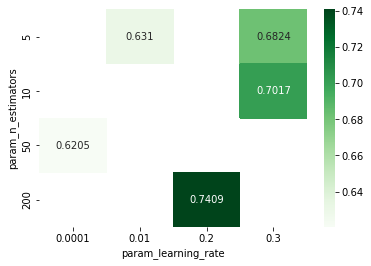

time: 348 ms (started: 2022-11-08 01:44:59 +00:00)


In [58]:
results = pd.DataFrame.from_dict(clf_gbdt.cv_results_)

max_scores = results.groupby(['param_n_estimators', 'param_learning_rate']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g', cmap = 'Greens');

## Applying our Best paramerters obtained by Hyperparameter tuning to our Model

In [59]:
# best parameters for our Decision Tree

best_learning_rate_tfidf = 0.2
best_estimator_tfidf = 200

print(" Best parameters for our XG Boost GBDT model based on TFIDF are:\n Best Learning rate = {0} &  \n Best estimator tfidf = {1}"
       .format(best_learning_rate_tfidf, best_estimator_tfidf))


gbdt_tfidf = XGBClassifier( learning_rate = best_learning_rate_tfidf, n_estimators = best_estimator_tfidf )

# fitting our model on Train data of TFIDF
gbdt_tfidf.fit(x_tr_tfidf, y_train )

# predicting on train and test data using predict_proba method
y_train_pred_tfidf = gbdt_tfidf.predict_proba(x_tr_tfidf)
y_test_pred_tfidf = gbdt_tfidf.predict_proba(x_te_tfidf)

 Best parameters for our XG Boost GBDT model based on TFIDF are:
 Best Learning rate = 0.2 &  
 Best estimator tfidf = 200
time: 1min 48s (started: 2022-11-08 01:45:15 +00:00)


Train Accuracy : 0.8648684701990289
Test Accuracy : 0.8462585034013606




Train Confusion Matrix:
[[  842  4935]
 [  130 31575]]
Test Confusion Matrix:
[[    7  1919]
 [    2 10567]]




Classification report for our Model's Training data:
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.15      0.25      5777
           1       0.86      1.00      0.93     31705

    accuracy                           0.86     37482
   macro avg       0.87      0.57      0.59     37482
weighted avg       0.87      0.86      0.82     37482





Classification report for our Model's Test data:
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.00      0.01      1926
           1       0.85      1.00      0.92     10569

    accuracy                           0.85     12495
   macro avg       0.81      0.50      0.46     12495
w

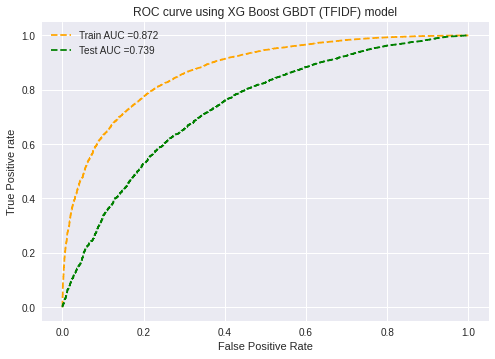



Plotting Train and Test Confusion matrices


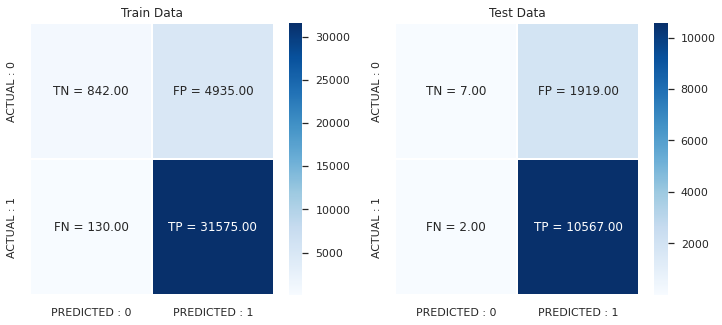

time: 8.43 s (started: 2022-11-08 01:47:25 +00:00)


In [60]:
# model_name = Our Model name, model = classifier used used to predict, y_train_pred, y_test_pred, x_train, x_test

evaluate_model ('XG Boost GBDT (TFIDF)', gbdt_tfidf, y_train_pred_tfidf, y_test_pred_tfidf, x_tr_tfidf, x_te_tfidf )

## using Set 2 TFIDF + W2V

In [61]:
model_W2V = XGBClassifier()

param = { 'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
          'n_estimators' : [5, 10, 50, 75, 100, 200]
        }

clf_gbdt_W2V = RandomizedSearchCV(model_W2V, param_distributions = param, scoring = 'roc_auc',
                                  cv = 5, n_jobs = -1, n_iter = 5, return_train_score = True, verbose = 10)  
clf_gbdt_W2V.fit(x_tr_tfidf_w2v, y_train)

print("Best value of Parameters for our XGBoost GBDT with TFIDF + W2V model are  :", clf_gbdt_W2V.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best value of Parameters for our XGBoost GBDT with TFIDF + W2V model are  : XGBClassifier(learning_rate=0.2, n_estimators=75)
time: 55min 58s (started: 2022-11-08 01:48:21 +00:00)


In [62]:
clf_gbdt_W2V.score(x_te_tfidf_w2v, y_test)      # just to test the values

0.7173001588630792

time: 3.56 s (started: 2022-11-08 02:48:09 +00:00)


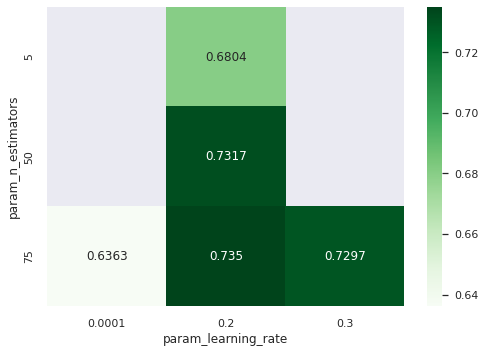

time: 358 ms (started: 2022-11-08 02:48:24 +00:00)


In [63]:
results_w2v = pd.DataFrame.from_dict(clf_gbdt_W2V.cv_results_)

max_scores = results_w2v.groupby(['param_n_estimators', 'param_learning_rate']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g', cmap = 'Greens');

## Applying our Best paramerters obtained by Hyperparameter tuning to our Model

In [64]:
# best parameters for our Decision Tree

best_learning_rate_tfidf_w2v = 0.2
best_estimator_tfidf_w2v = 75

print(" Best parameters for our XG Boost GBDT model based on TFIDF are:\n Best Learning rate = {0} &  \n Best estimator tfidf = {1}"
       .format(best_learning_rate_tfidf_w2v, best_estimator_tfidf_w2v))


gbdt_tfidf_w2v = XGBClassifier( learning_rate = best_learning_rate_tfidf_w2v, n_estimators = best_estimator_tfidf_w2v )

# fitting our model on Train data of TFIDF + W2V
gbdt_tfidf_w2v.fit(x_tr_tfidf_w2v, y_train )

# predicting on train and test data using predict_proba method
y_train_pred_tfidf_w2v = gbdt_tfidf_w2v.predict_proba(x_tr_tfidf_w2v)
y_test_pred_tfidf_w2v = gbdt_tfidf_w2v.predict_proba(x_te_tfidf_w2v)

 Best parameters for our XG Boost GBDT model based on TFIDF are:
 Best Learning rate = 0.2 &  
 Best estimator tfidf = 75
time: 3min 51s (started: 2022-11-08 02:49:10 +00:00)


Train Accuracy : 0.8564644362627395
Test Accuracy : 0.8458583433373349




Train Confusion Matrix:
[[  524  5253]
 [  127 31578]]
Test Confusion Matrix:
[[    1  1925]
 [    1 10568]]




Classification report for our Model's Training data:
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.09      0.16      5777
           1       0.86      1.00      0.92     31705

    accuracy                           0.86     37482
   macro avg       0.83      0.54      0.54     37482
weighted avg       0.85      0.86      0.80     37482





Classification report for our Model's Test data:
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.00      0.00      1926
           1       0.85      1.00      0.92     10569

    accuracy                           0.85     12495
   macro avg       0.67      0.50      0.46     12495
w

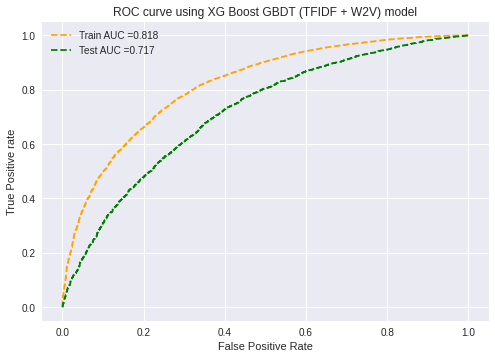



Plotting Train and Test Confusion matrices


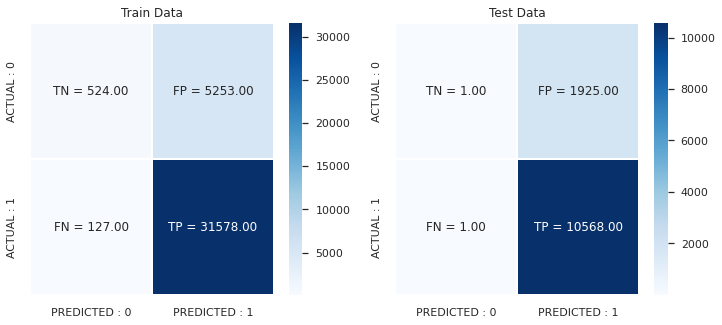

time: 50.2 s (started: 2022-11-08 02:55:33 +00:00)


In [65]:
# model_name = Our Model name, model = classifier used used to predict, y_train_pred, y_test_pred, x_train, x_test

evaluate_model ('XG Boost GBDT (TFIDF + W2V)', gbdt_tfidf_w2v, y_train_pred_tfidf_w2v, y_test_pred_tfidf_w2v, x_tr_tfidf_w2v, x_te_tfidf_w2v )

In [66]:
# initializing a table
table = PrettyTable()

# adding title to our table
table.title = "XG Boost GBDT on Donoros Choose Dataset"
# adding column names to our table
table.field_names = ["Vectorizer", "Model", "Learning rate", "Estimator"," AUC"]

# adding rows to our table
table.add_row(['TFIDF', 'XG Boost GBDT', best_learning_rate_tfidf, best_estimator_tfidf, '0.739'])
table.add_row(['TFIDF + W2V', 'XG Boost GBDT', best_learning_rate_tfidf_w2v, best_estimator_tfidf_w2v, '0.717' ])
  
# printing the table
print(table)

+-----------------------------------------------------------------+
|             XG Boost GBDT on Donoros Choose Dataset             |
+-------------+---------------+---------------+-----------+-------+
|  Vectorizer |     Model     | Learning rate | Estimator |   AUC |
+-------------+---------------+---------------+-----------+-------+
|    TFIDF    | XG Boost GBDT |      0.2      |    200    | 0.739 |
| TFIDF + W2V | XG Boost GBDT |      0.2      |     75    | 0.717 |
+-------------+---------------+---------------+-----------+-------+
time: 2.61 ms (started: 2022-11-08 02:56:51 +00:00)
